# Data Collection


In [1]:
import requests
import pandas as pd

# Fetch the data from the URL with length set to 10000
url = "https://datasets-server.huggingface.co/rows?dataset=HuggingFaceM4%2FWebSight&config=v0.2&split=train&offset=0&length=10000"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Load the data into a pandas DataFrame
    df = pd.json_normalize(data['rows'])  # Adjusted to access the 'rows' field in the JSON response
    # Display the DataFrame
    print(df.head())
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


   row_idx truncated_cells                                      row.image.src  \
0        0              []  https://datasets-server.huggingface.co/cached-...   
1        1              []  https://datasets-server.huggingface.co/cached-...   
2        2              []  https://datasets-server.huggingface.co/cached-...   
3        3              []  https://datasets-server.huggingface.co/cached-...   
4        4              []  https://datasets-server.huggingface.co/cached-...   

   row.image.height  row.image.width  \
0              1440             2560   
1              1440             2560   
2              1440             2560   
3              1440             2560   
4              2008             2560   

                                            row.text  \
0  <html>\n<link href="https://cdn.jsdelivr.net/n...   
1  <html>\n<link href="https://cdn.jsdelivr.net/n...   
2  <html>\n<link href="https://cdn.jsdelivr.net/n...   
3  <html>\n<link href="https://cdn.jsdelivr.net/

In [2]:
df.shape

(100, 7)

##Preprocessing

In [3]:
# Dropping irrelevent columns
df = df.drop(columns=['row_idx','truncated_cells','row.image.height','row.image.width'],axis=1)

# Renaming the columns
df = df.rename(columns={'row.text': 'output',
                       'row.image.src':'image',
                        'row.llm_generated_idea':'input'
                        })


In [ ]:
df

,image,output,input
0,https://datasets-server.huggingface.co/cached-...,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Fashion Brand: A visually stunning layout with...
1,https://datasets-server.huggingface.co/cached-...,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Restaurant Chain: A design with a mouth-wateri...
2,https://datasets-server.huggingface.co/cached-...,"<html>\n<link href=""https://cdn.jsdelivr.net/n...","Consulting Firm: A clean, professional design ..."
3,https://datasets-server.huggingface.co/cached-...,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Real Estate Agency: A user-friendly design wit...
4,https://datasets-server.huggingface.co/cached-...,"<html>\n<link href=""https://cdn.jsdelivr.net/n...","Education Platform: A design with a wide, hero..."
...,...,...,...
95,https://datasets-server.huggingface.co/cached-...,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Educational Institution: A scrolling design wh...
96,https://datasets-server.huggingface.co/cached-...,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Tech Startup: A minimalist design with a contr...
97,https://datasets-server.huggingface.co/cached-...,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Art Gallery: A slideshow or gallery-style layo...
98,https://datasets-server.huggingface.co/cached-...,"<html>\n<link href=""https://cdn.jsdelivr.net/n...","Construction Company: A full-width, single-pag..."


## Setting environment variable

In [4]:
import os
from google.colab import userdata

# Set environment variables
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [5]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U "keras>=3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.2/572.2 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 98.7 MB/s eta 0:00:00


In [6]:
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

# Import Packages


In [7]:
import keras
import keras_nlp


#
*Data* preparation

In [8]:
# Extract input and output texts
input_texts = df['input'].tolist()
output_texts = df['output'].tolist()
data = []
for input, output in zip(input_texts, output_texts):
    data.append(f"Instruction:\n{input}\n\nResponse:\n{output}")


In [9]:
data[:1]

['Instruction:\nFashion Brand: A visually stunning layout with a full-width, rotating image carousel showcasing their latest collections, a bold, center-aligned logo, and a bottom navigation menu. The color palette is inspired by the latest fashion trends.\n\nResponse:\n<html>\n<link href="https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css" rel="stylesheet">\n<body class="bg-gray-100">\n  <div class="flex flex-col items-center justify-center h-screen">\n    <h1 class="text-4xl font-bold text-center text-gray-800">Fashion Brand</h1>\n    <p class="mt-4 text-lg text-center text-gray-600">\n      Fashion Brand is a leading fashion brand that offers a wide range of high-quality, stylish clothing and accessories. Our collections are designed to reflect the latest fashion trends and are made from high-quality materials. We are committed to providing our customers with the best possible shopping experience and we strive to make our collections accessible to all.\n    </p>\n

# Load Model

In [10]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_2b_en")
gemma_lm.summary()

100%|██████████| 143/143 [00:00<00:00, 253kB/s]


100%|██████████| 782/782 [00:00<00:00, 1.69MB/s]


100%|██████████| 4.87G/4.87G [05:30<00:00, 15.8MB/s]


100%|██████████| 315/315 [00:00<00:00, 289kB/s]


100%|██████████| 4.04M/4.04M [00:01<00:00, 2.22MB/s]


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

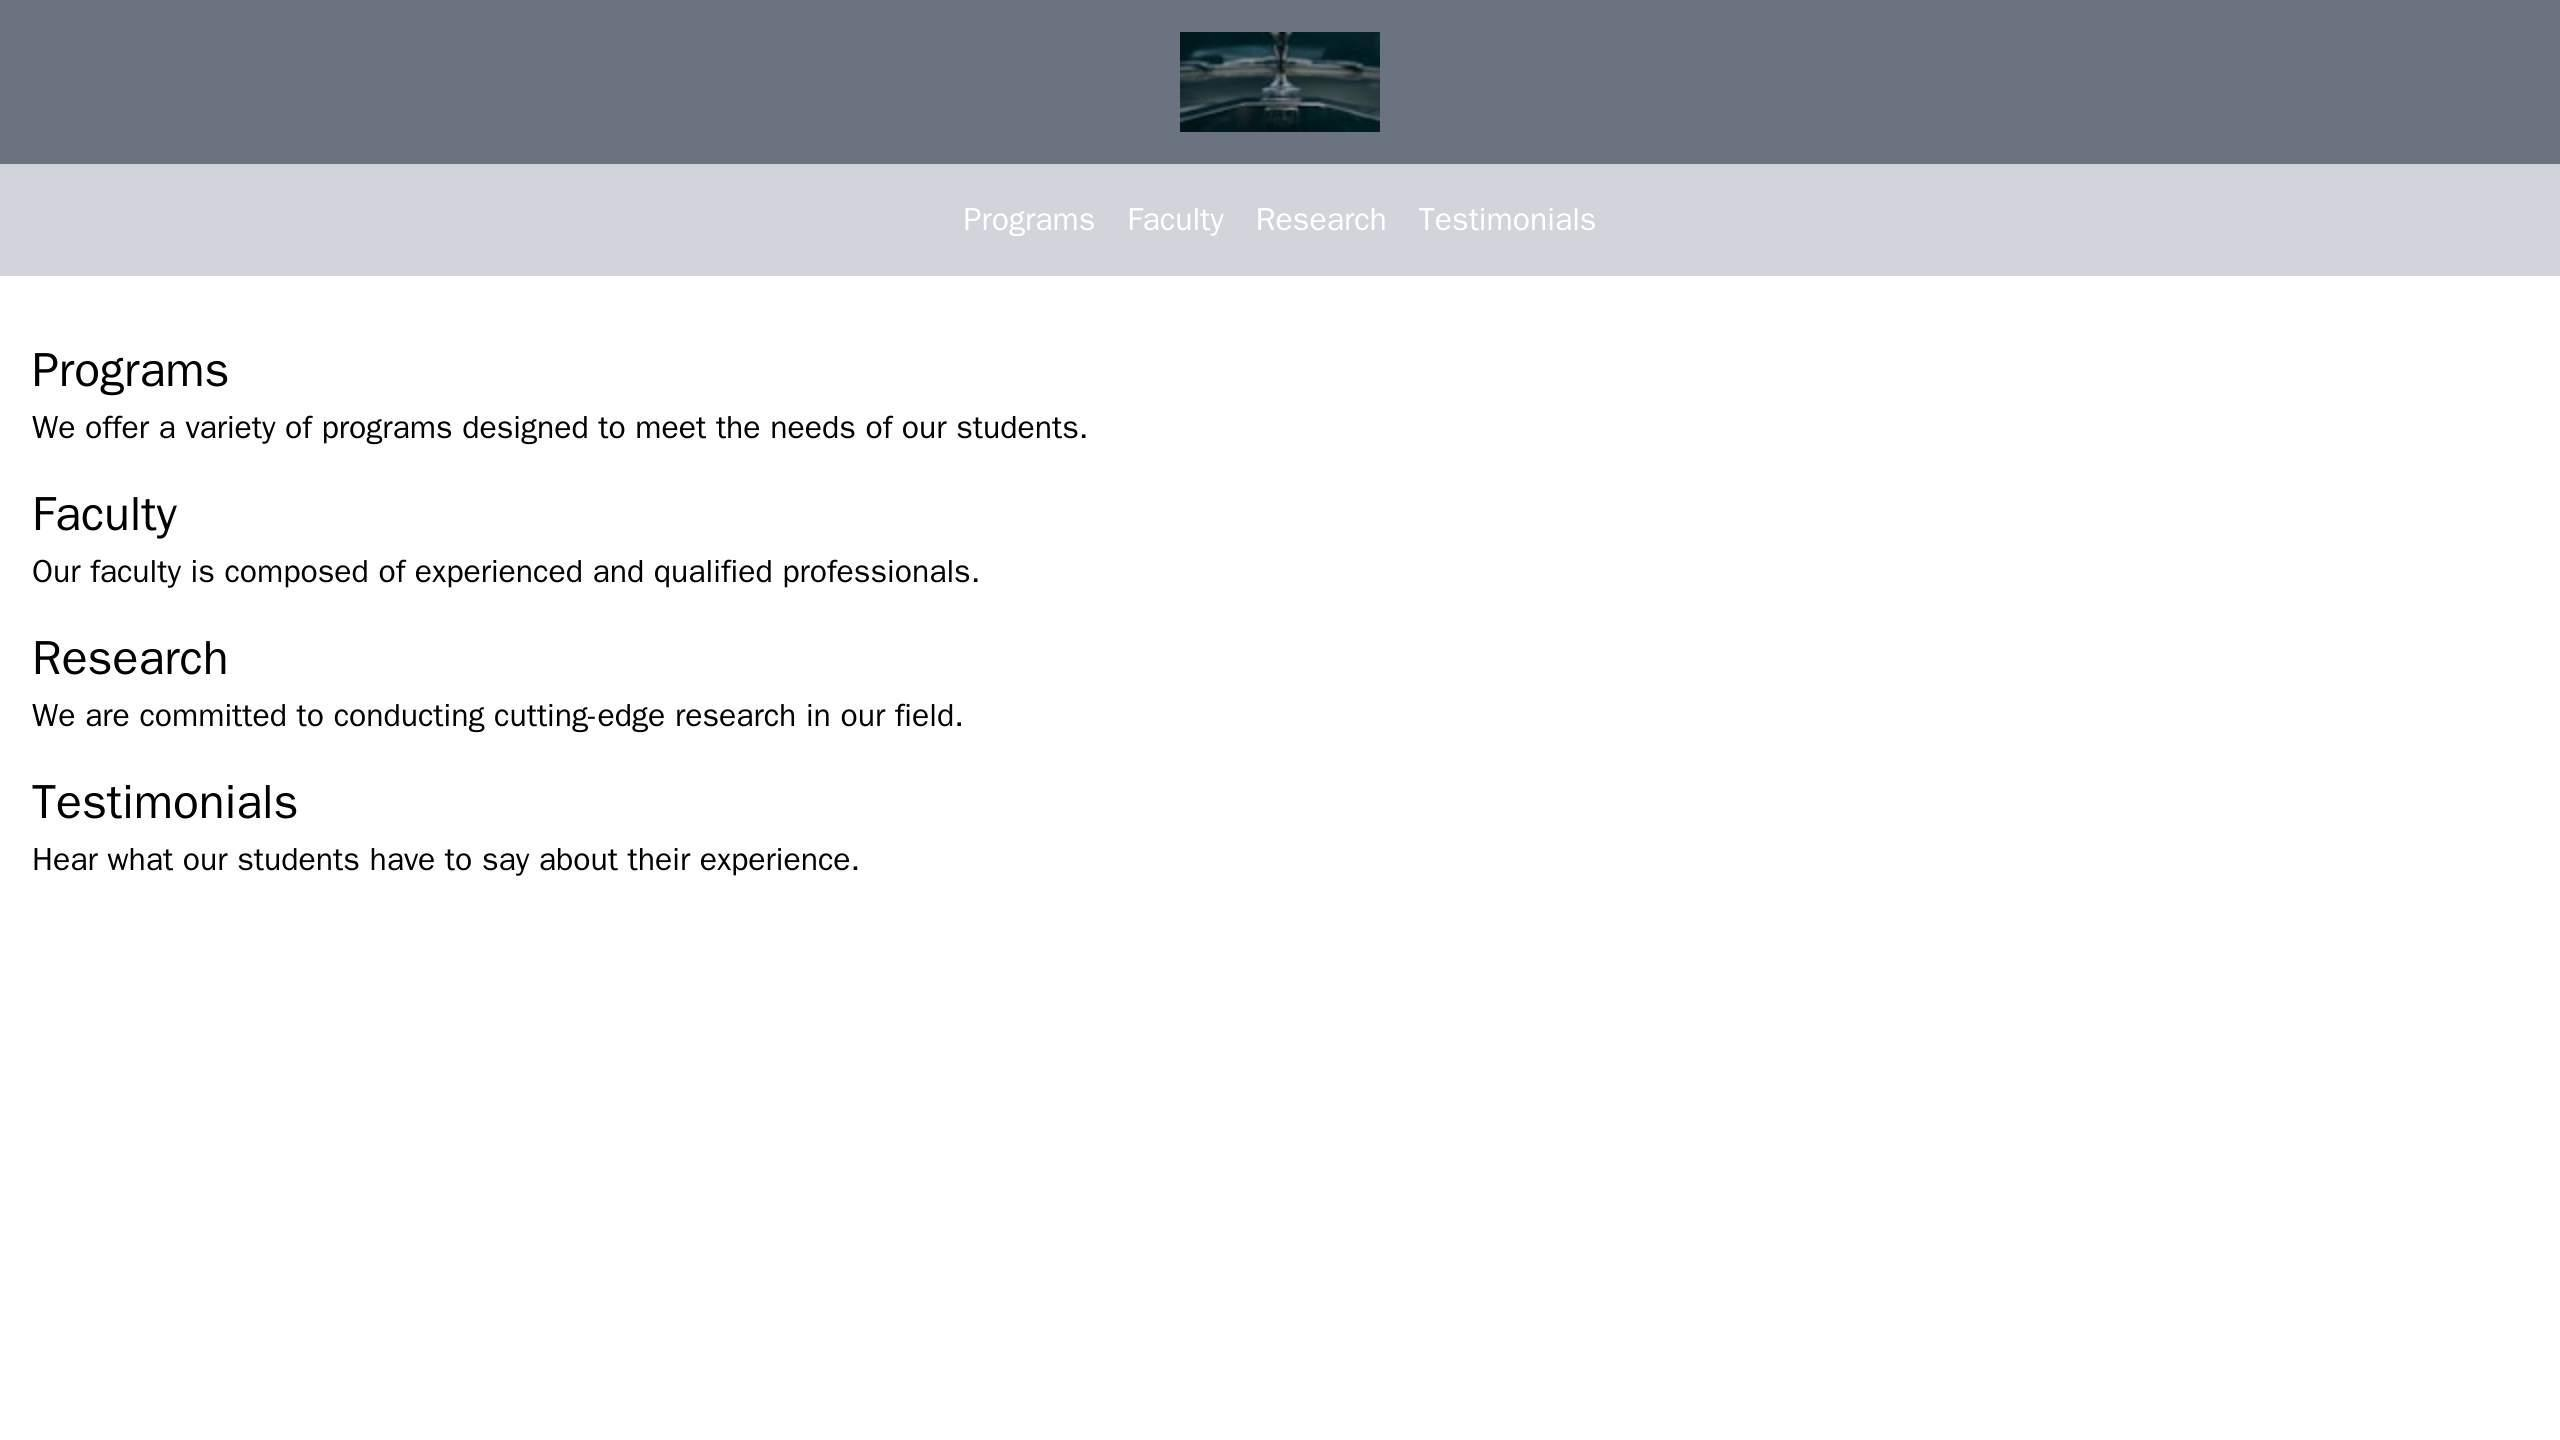

Educational Institute: A professional and authoritative design with a clean color scheme and plenty of white space. The logo is positioned at the top center, and the main navigation menu is located horizontally across the top. The main content includes sections on programs, faculty, research, and student testimonials, with a clear call-to-action (CTA) for potential students to apply.


In [11]:
# Taking the same prompt to get website
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
prompt = template.format(
    instruction="Educational Institute: A professional and authoritative design with a clean color scheme and plenty of white space. The logo is positioned at the top center, and the main navigation menu is located horizontally across the top. The main content includes sections on programs, faculty, research, and student testimonials, with a clear call-to-action (CTA) for potential students to apply.",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
Educational Institute: A professional and authoritative design with a clean color scheme and plenty of white space. The logo is positioned at the top center, and the main navigation menu is located horizontally across the top. The main content includes sections on programs, faculty, research, and student testimonials, with a clear call-to-action (CTA) for potential students to apply.

Response:
A well-designed, informative, and visually appealing website that effectively communicates the mission of the educational institute.


From this we can see that the response is not in HTML for given prompt. Let's Finetune it 😊.

## LoRA Fine-tuning


In [12]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

In [13]:
# Limit the input sequence length to 128 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 128
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

gemma_lm.fit(data, epochs=1, batch_size=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 716ms/step - loss: 1.9102 - sparse_categorical_accuracy: 0.6371


In [14]:
prompt

'Instruction:\nEducational Institute: A professional and authoritative design with a clean color scheme and plenty of white space. The logo is positioned at the top center, and the main navigation menu is located horizontally across the top. The main content includes sections on programs, faculty, research, and student testimonials, with a clear call-to-action (CTA) for potential students to apply.\n\nResponse:\n'

In [18]:
print(gemma_lm.generate(prompt, max_length=2000))

Instruction:
Educational Institute: A professional and authoritative design with a clean color scheme and plenty of white space. The logo is positioned at the top center, and the main navigation menu is located horizontally across the top. The main content includes sections on programs, faculty, research, and student testimonials, with a clear call-to-action (CTA) for potential students to apply.

Response:
<html>
<link href="https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css" rel="stylesheet">
<body class="bg-gray-100">
<header class="bg-white py-6 px-4 sm:px-6 lg:px-8">
    <div class="container mx-auto flex justify-between items-center">
        <a href="/" class="flex items-center">
            <img src="https://tailwindui.com/img/logos/workflow-mark-indigo-500.svg" alt="Workflow" class="block w-6 h-6">
            <span class="ml-2 text-2xl font-bold tracking-wide text-gray-900 uppercase">Educational Institute</span>
        </a>
        <nav class="hidden space

In [20]:
from IPython.display import display, HTML

html_content = """
<html>
<link href="https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css" rel="stylesheet">
<body class="bg-gray-100">
<header class="bg-white py-6 px-4 sm:px-6 lg:px-8">
    <div class="container mx-auto flex justify-between items-center">
        <a href="/" class="flex items-center">
            <img src="https://tailwindui.com/img/logos/workflow-mark-indigo-500.svg" alt="Workflow" class="block w-6 h-6">
            <span class="ml-2 text-2xl font-bold tracking-wide text-gray-900 uppercase">Educational Institute</span>
        </a>
        <nav class="hidden space-x-8 sm:-my-4 sm:ml-10 sm:flex">
            <a href="/" class="font-medium text-gray-500 hover:text-gray-900">Home</a>
            <a href="/about" class="font-medium text-gray-500 hover:text-gray-900">About</a>
            <a href="/programs" class="font-medium text-gray-500 hover:text-gray-900">Programs</a>
            <a href="/faculty" class="font-medium text-gray-500 hover:text-gray-900">Faculty</a>
            <a href="/research" class="font-medium text-gray-500 hover:text-gray-900">Research</a>
            <a href="/contact" class="font-medium text-gray-500 hover:text-gray-900">Contact</a>
        </nav>
        <div class="hidden sm:flex sm:items-center sm:ml-6">
            <div class="mr-2 flex h-10 items-center">
                <a href="#" class="inline-flex rounded-md">
                    <svg xmlns="http://www.w3.org/2000/svg" class="h-6 w-6 text-gray-400" fill="none" viewBox="0 0 24 24" stroke="currentColor">
                        <path stroke-linecap="round" stroke-linejoin="round" stroke-width="2" d="M17 16l4-4m0 0l-4-4m4 4H7m6 4v1a3 3 0 01-3 3H6a3 3 0 01-3-3V7a3 3 0 013-3h4a3 3 0 013 3v1" />
                    </svg>
                </a>
            </div>
            <div class="ml-3 relative">
                <input type="text" id="search" name="search" class="block w-full rounded-md border-gray-300 pl-10 pr-4 text-base placeholder-gray-500 focus:border-indigo-500 focus:ring-2 focus:ring-indigo-200 sm:text-sm">
                <button type="submit" class="absolute right-0 top-0 mt-3 mr-2.5 h-10 w-10 rounded-md bg-indigo-500 text-white focus:outline-none focus:ring-2 focus:ring-indigo-500">
                    <svg xmlns="http://www.w3.org/2000/svg" class="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor">
                        <path stroke-linecap="round" stroke-linejoin="round" stroke-width="2" d="M21 21l-6-6m2-5a7 7 0 11-14 0 7 7 0 0114 0z" />
                    </svg>
                </button>
            </div>
        </div>
    </div>
</header>
<main>
    <div class="max-w-7xl mx-auto py-12 px-4 sm:px-6 lg:py-16 lg:px-8">
        <div class="text-center">
            <h1 class="text-4xl tracking-tight font-extrabold text-gray-900 sm:text-5xl md:text-6xl">
                <span class="block xl:inline">Welcome to</span>
                <span class="block text-indigo-600 xl:inline">Educational Institute</span>
            </h1>
            <p class="mt-3 text-base text-gray-500">
                Lorem ipsum dolor sit amet, consectetur adipisicing elit. Quibusdam,
                excepturi, vero, odit, voluptate, fugiat, laboriosam, aliquam,
                quos, tempore, fugiat, voluptates, nihil.
            </p>
        </div>
        <div class="mt-10">
            <div class="grid gap-10 lg:grid-cols-12">
                <div class="col-span-12 lg:col-span-8">
                    <article class="mt-10">
                        <h2 class="section-header text-base font-medium text-gray-900">
                            Programs
                        </h2>
                        <p class="mt-3 text-base text-gray-500">
                            Lorem ipsum dolor sit amet, consectetur adipisicing elit.
                            Quibusdam, excepturi, vero, odit, voluptate, fugiat, laboriosam,
                            aliquam, quos, tempore, fugiat, voluptates, nihil.
                        </p>
                        <ul role="list" class="mt-10 space-y-10">
                            <li class="flow-root">
                                <a href="#" class="flex items-center block px-4 py-2 text-base font-medium text-indigo-700 rounded-md hover:bg-indigo-50">
                                    <svg xmlns="http://www.w3.org/2000/svg" class="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor">
                                        <path stroke-linecap="round" stroke-linejoin="round" stroke-width="2" d="M12 6v6m0 0v6m0-6h6m-6 0H6" />
                                    </svg>
                                    <span class="ml-3">Web Development</span>
                                </a>
                            </li>
                            <li class="flow-root">
                                <a href="#" class="flex items-center block px-4 py-2 text-base font-medium text-indigo-700 rounded-md hover:bg-indigo-50">
                                    <svg xmlns="http://www.w3.org/2000/svg" class="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor">
                                        <path stroke-linecap="round" stroke-linejoin="round" stroke-width="2" d="M12 6v6m0 0v6m0-6h6m-6 0H6" />
                                    </svg>
                                    <span class="ml-3">Data Science</span>
                                </a>
                            </li>
                            <li class="flow-root">
                                <a href="#" class="flex items-center block px-4 py-2 text-base font-medium text-indigo-700 rounded-md hover:bg-indigo-50">
                                    <svg xmlns="http://www.w3.org/2000/svg" class="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor">
                                        <path stroke-linecap="round" stroke-linejoin="round" stroke-width="2" d="M1
"""

display(HTML(html_content))
